In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from lsst.daf.butlerUtils import ExposureIdInfo

import lsst.afw.display            as afwDisplay
import lsst.daf.base               as dafBase
import lsst.afw.image              as afwImage
import lsst.afw.geom               as afwGeom
import lsst.afw.table              as afwTable

import lsst.meas.algorithms        as measAlg

In [3]:

from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate         import CalibrateTask
from lsst.meas.algorithms.detection    import SourceDetectionTask
from lsst.meas.deblender               import SourceDeblendTask
from lsst.meas.base                    import SingleFrameMeasurementTask

import lsst.afw.display.utils as afwDisplayUtils
import lsst.afw.image.utils as afwImageUtils

In [4]:
import lsst.meas.extensions.psfex.psfexPsfDeterminer


In [5]:
disp  = afwDisplay.Display(1);  disp.callbacks  = disp._callbacks
disp2 = afwDisplay.Display(2);  disp2.callbacks = disp2._callbacks

In [6]:
schema = afwTable.SourceTable.makeMinimalSchema()
algMetadata = dafBase.PropertyList()

config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
if True:
    config.measurePsf.psfDeterminer.name = "pca"   # the default
else:
    config.measurePsf.psfDeterminer.name = "psfex"
    
charImageTask =         CharacterizeImageTask(None, config=config)

config = SourceDetectionTask.ConfigClass()
sourceDetectionTask =   SourceDetectionTask(schema=schema, config=config)

sourceDeblendTask =     SourceDeblendTask(schema=schema)

config = SingleFrameMeasurementTask.ConfigClass()
config.doApplyApCorr = 'yes'
config.slots.apFlux = 'base_CircularApertureFlux_12_0'
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config,
                                                   algMetadata=algMetadata)

In [7]:
fileName = "example2.fits"
exposureIdInfo = ExposureIdInfo(0, 5)

exposure = afwImage.ExposureF(fileName)

tab = afwTable.SourceTable.make(schema)

result = charImageTask.characterize(exposure, exposureIdInfo)
psfCellSet = result.psfCellSet     # we'll look at this data structure later

result = sourceDetectionTask.run(tab, exposure)
sources = result.sources

sourceDeblendTask.run(exposure, sources, exposure.getPsf())

sourceMeasurementTask.run(exposure, sources)

sources.writeFits("outputTable.fits")
exposure.writeFits("example2-out.fits")

# these don't run without error here, but in the test_image_processing
# they do - not sure exactly why

In [8]:
sources = sources.copy(True)

good = np.logical_and.reduce([sources.get('base_PixelFlags_flag_saturatedCenter') == 0,
                              sources.get("deblend_nChild") == 0,
                              ])

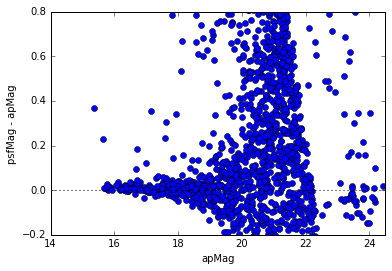

In [9]:
with afwImageUtils.CalibNoThrow():
    apMag = exposure.getCalib().getMagnitude(sources.getApFlux())
    psfMag = exposure.getCalib().getMagnitude(sources.getPsfFlux())

plt.plot(apMag[good], (psfMag - apMag)[good], 'o')

plt.axhline(0.0, ls=':', color='black')
plt.xlim(14, 24.5)
plt.ylim(-0.2, 0.8)

plt.xlabel("apMag")
plt.ylabel("psfMag - apMag")

plt.show()
# this graph has a lot more on it (i.e. something)
# whereas the equivalent graph in test_image_processing
# has much less (i.e. nothing) - should figure out what is going on here

In [10]:
if True:
    disp2.mtv(exposure)
else:
    disp2.erase()

if psfCellSet:
    with disp2.Buffering():
        for cell in psfCellSet.getCellList():
            afwDisplayUtils.drawBBox(cell.getBBox(), display=disp2, 
                                     borderWidth=0.5, ctype=afwDisplay.CYAN)

            for cand in cell:
                disp2.dot("*", cand.getXCenter(), cand.getYCenter(),
                          ctype=afwDisplay.GREEN if cand.GOOD else afwDisplay.RED)

In [11]:

residuals = exposure.getMaskedImage().getImage().clone()
psf = exposure.getPsf()

with disp.Buffering():
    for s in sources[good]:
        psfImage = psf.computeImage(s.getCentroid()).convertF()
        psfImage *= s.getPsfFlux()/np.sum(psfImage.getArray())
            
        try:
            residuals[psfImage.getBBox()] -= psfImage
        except:
            pass
            
disp.mtv(residuals)

with disp.Buffering():
    for s in sources[good]:
        disp.dot("o", *s.getCentroid(), size=20) 